<a href="https://colab.research.google.com/github/tranant2/CMSE823FinalProject/blob/main/CMSE_823_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
!pip install qiskit

In [74]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import time


import qiskit
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.providers.aer import noise
from qiskit.providers.aer.noise import NoiseModel
from qiskit.tools.visualization import *
from qiskit import IBMQ
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

#Data Generation

In [75]:
def getDataset(N, m, n):
  return (np.random.rand(m*n*N)).reshape(-1,m,n)  

def Data(N,m,n):
  """
  TODO: Currently, it's not allowing any matrixes larger than 32x64 to be made singular
  Same as getDataset, but check to make sure matrices are all non-singular.
  All values in matrices are random numbers less than 1.
  Input:
  N: number of matrices wanted
  m,n: size of matrix

  Output:
  N (mxn) matrices.
  """
  mat = []
  A = (np.random.rand(m*n*N)).reshape(-1,m,n)
  for i in range(len(A)):
    while LA.det(A[i].T@A[i])==0:
      A[i] = (np.random.rand(m*n)).reshape(m,n) 
    mat.append(A[i])
  return mat

def get_Data_avg_time(N,m,n):
  """
  Return average time to create each matrix
  and the dataset
  """
  t0 = time.time_ns()
  #setmxn = Data(N, m, n)
  setmxn = getDataset(N, m, n)*.9  # make dataset less than .9
  t1 = time.time_ns()
  avg = (t1-t0)/(N)*1e-9
  return setmxn, avg

In [76]:
# size
n = 10000
n2 = 1000
n = 1000
n2 = 100

In [77]:
nxn_size = [n,n,n,n2,n2,n2]
mxn_size = [n,n,n,n,n2,n2,n2]

##nxn

In [78]:
%%time 
# This give the time of the whole cell

avgnxn = [None]*6

set4x4, avgnxn[0] = get_Data_avg_time(n,4,4)
set16x16, avgnxn[1] = get_Data_avg_time(n,16,16)
set64x64, avgnxn[2] = get_Data_avg_time(n,64,64)
set128x128, avgnxn[3] = get_Data_avg_time(n2,128,128)
set256x256, avgnxn[4] = get_Data_avg_time(n2,256,256)
set512x512, avgnxn[5] = get_Data_avg_time(n2,512,512)

CPU times: user 447 ms, sys: 410 ms, total: 856 ms
Wall time: 893 ms


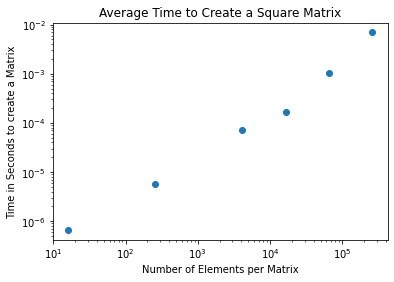

In [79]:
x = np.array([4,16,64,128,256,512])**2  # x axis is the number of elements
plt.scatter(x, avgnxn)  # Plot of average time to create a matrix
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Elements per Matrix')
plt.ylabel('Time in Seconds to create a Matrix')
plt.title("Average Time to Create a Square Matrix")
plt.savefig("nxn_averagemake_time.png", dpi=300)

In [80]:
nxn_data = [set4x4,set16x16,set64x64,set128x128,set256x256,set512x512]

##mxn

In [81]:
%%time

avgmxn = [None]*7

# set2x4, avgmxn[0] = get_Data_avg_time(n,2,4)
# set4x16, avgmxn[1] = get_Data_avg_time(n,4,16)
# set16x32, avgmxn[2] = get_Data_avg_time(n,16,32)
# set32x64, avgmxn[3] = get_Data_avg_time(n,32,64)
# set64x128, avgmxn[4] = get_Data_avg_time(n2,64,128)
# set128x256, avgmxn[5] = get_Data_avg_time(n2,128,256)
# set256x512, avgmxn[6] = get_Data_avg_time(n2,256,512)

set4x2, avgmxn[0] = get_Data_avg_time(n,4,2)
set16x4, avgmxn[1] = get_Data_avg_time(n,16,4)
set32x16, avgmxn[2] = get_Data_avg_time(n,32,16)
set64x32, avgmxn[3] = get_Data_avg_time(n,64,32)
set128x64, avgmxn[4] = get_Data_avg_time(n2,128,64)
set256x128, avgmxn[5] = get_Data_avg_time(n2,256,128)
set512x256, avgmxn[6] = get_Data_avg_time(n2,512,256)

CPU times: user 200 ms, sys: 92.4 ms, total: 293 ms
Wall time: 294 ms


In [82]:
mxn_data = [set4x2, set16x4, set32x16, set64x32, set128x64, set256x128, set512x256]

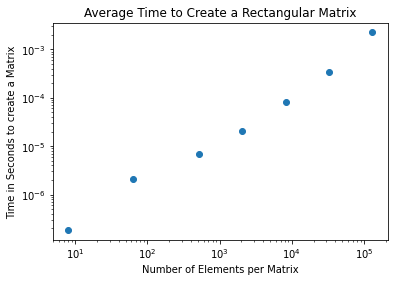

In [83]:
x = np.array([2,4,16,32,64,128,256])*np.array([4,16,32,64,128,256,512])
plt.scatter(x, avgmxn)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Elements per Matrix')
plt.ylabel('Time in Seconds to create a Matrix')
plt.title("Average Time to Create a Rectangular Matrix")
plt.savefig("mxn_averagemake_time.png", dpi=300)

#Psudo-inverses

##QR/Cholesky/LUP/SVD

The following shows how to get the psudo-inverses for the different algorithms.

###QR
$A^+=(A^*A)^{-1}A^*$

$A^*A=QR$

$(A^*A)^{-1}=R^{-1}Q^*$

$A^+=R^{-1}Q^*A^*$

###Cholesky
$A^+=(A^*A)^{-1}A^*$

$A^*A=LU$

$A^+=U^{-1}L^{-1}A^*$

###LU
$A^+=(A^*A)^{-1}A^*$

$A=LU$

$A^*=U^*L^*$

$A^+=(U^*L^*LU)^{-1}U^*L^*$

$=U^{-1}L^{-1}$

### LUP

With pivoting we get PA=LU. Since $P^TP=I$, we can do similar calculations

$A^+=(A^*A)^{-1}A^*$

$P(A^*A)=LU$

$(A^*A)^{-1}=U^{-1}L^{-1}P$

$A^+=U^{-1}L^{-1}PA^*$

###SVD
1. Form $AA^*$
2. Compute the eigenvalue decomposion of $A^*A=V\Lambda V^*$
3. Let $\Sigma$ be the $mxn$ nonnegative diagonal square root of $\Lambda$
4. Solve the system $U\Sigma=AV$ for unitary $U$

$A = U\Sigma V^*$

$A^* = V\Sigma^{-1}U$

In [84]:
def SVD(M):
  """
  Calculate Standard Value Decomposition using direct method.
  """
  w,v = LA.eig(M.T@M)
  mask = np.argsort(w)
  mask = mask[::-1]
  w = w[mask]
  v = v[:,mask] 
  sigma = np.sqrt(np.abs(w))
  Sigma = np.zeros(M.shape)
  SigmaInv = np.zeros(M.shape[::-1])
  for i in range(np.min(Sigma.shape)):
    Sigma[i,i] = sigma[i]
    SigmaInv[i,i] = 1/sigma[i] 
  u = M@v@SigmaInv
  return u,sigma,np.conj(v.T)

def getInvSVD(M):
  """
  Calculate the inverse of the SVD by first creating the inverse of the
  sigma matrix directly, then multiply by V and U accordingly.
  """
  U,S,VT = SVD(M)
  shape = M.shape
  S_ = np.zeros((shape[::-1]))
  for i in range(np.min(M.shape)):
    S_[i,i] = 1/S[i]
  return np.real(np.conj(VT.T)@S_@np.conj(U.T))
  
def mgs(A):
	"""Modified Gram-Schmidt algorithm"""
	m = np.shape(A)[0]
	n = np.shape(A)[1]
	Q =  np.zeros((m, n))
	R =  np.zeros((n, n)) 
	for j in range(n):
		v = A[:,j]
		for i in range(j):
			R[i,j] = np.dot(Q[:,i].T,A[:,j])
			v = v - np.dot(Q[:,i],R[i,j])
		R[j,j] =  np.linalg.norm(v)
		Q[:,j] = (v/R[j,j])
	return Q,R

def getQRpinv(A):
  """Get psuedo-inverse from QR"""
  Q,R = mgs(A.T@A)
  return LA.inv(R)@Q.T@A.T

def getQRinv(A):
  """Get inverse from QR"""
  Q,R = mgs(A)
  return LA.inv(R)@Q.T

def choleskyD(A):
  """Cholesky Decomposition"""
  n = A.shape[0]
  L = np.zeros((n, n), dtype=np.double)
  for i in range(n):
    for k in range(i+1):
        tmp_sum = sum(L[i][j] * L[k][j] for j in range(k))
        if (i == k): 
            L[i][k] = np.sqrt(np.real(A[i][i] - tmp_sum))
        else:
            L[i][k] = (1.0 / L[k][k] * (A[i][k] - tmp_sum))
  return L

def cholesky(A):
  """Get psuedo-inverse from Cholesky"""
  L = choleskyD(A.T@A)
  return LA.inv(L@L.T)@A.T

def LU(H):  # Actually works for nxm as well
    """
    Implementation of LU factorization
    """
    m = H.shape[0]
    n = H.shape[1]
    L = np.eye(m)
    U = np.matrix.copy(H)
    for k in range(n-1):
        for j in range(k+1,m):
            L[j,k] = U[j,k]/U[k,k]
            U[j,k:] = U[j,k:] - L[j,k]*U[k,k:]
    return L,U

def LUP(H):  # Add pivoting for stability
  """
  Implementation of LU factorization with pivoting.
  Assume square matrix else,
  Assumes first index is less than second index. m<n
  so doesn't work on all rectangular matrices
  """
  m = H.shape[0]
  n = H.shape[1]
  L = np.eye(m)
  P = np.eye(m)
  U = np.matrix.copy(H)
  for k in range(m-1): # to right
    tempU = U[k:,k]
    max_index = np.argmax(tempU)+k
    U[[k,max_index],k:] = U[[max_index,k],k:] # switch rows
    L[[k,max_index],:k] = L[[max_index,k],:k] # switch rows
    P[[k,max_index],:] = P[[max_index,k],:] # switch rows
    for j in range(k+1,m): # go down
      L[j,k] = U[j,k]/U[k,k]
      U[j,k:] = U[j,k:] - L[j,k]*U[k,k:]
  return L,U,P

def getLUPpinv(H):
  """Get psuedo-inverse from LUP"""
  L,U,P = LUP(H.T@H)
  return LA.inv(U)@LA.inv(L)@P@H.T

def getLUPinv(H):
  """Get inverse from LUP"""
  L,U,P = LUP(H)
  return LA.inv(U)@LA.inv(L)@P

Testing that the psudo-inverses works.

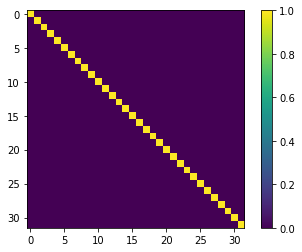

In [85]:
A = set64x32[1];
A_ = getInvSVD(A)
plt.imshow(A_@A)
plt.colorbar()

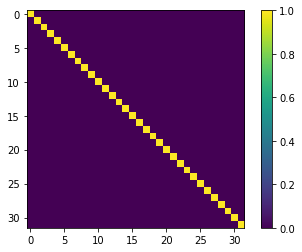

In [86]:
A = set64x32[1];
A_ = getQRinv(A)
plt.imshow(A_@A)
plt.colorbar()

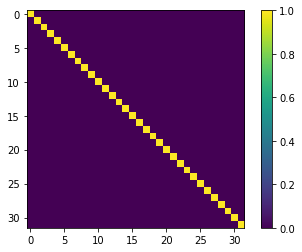

In [87]:
A = set64x32[1];
A_ = cholesky(A)
plt.imshow(A_@A)
plt.colorbar()

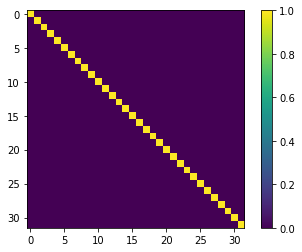

In [88]:
A = set64x32[1];
A_ = getLUPpinv(A)
plt.imshow(A_@A)
plt.colorbar()

In [89]:
def get_psudeoInv_avg(x, mxn_size, mxn_data, f):
  """
  function to calculate psudo-inverse and collact data on its average
  x : x axis which tells the total number of elements for each dataset
  mxnsize : array which contains the total number of matrices for each dataset
  mxn_data : array which contains the dataset
  f : function f(A)=A^-1, which calculates the psudeo-inverse a matrix at a time

  Return:
  inv_avg : avg time of each set
  inv_data : the psudo-invereted matrices
  """
  if len(x) != len(mxn_size):
    print("x doesn't match mxn_size array")
    return 
  if len(mxn_data) != len(mxn_data):
    print("dataset size doesn't match nsize")
    return 
  size = len(x)
  inv_avg = [None]*size
  inv_data = [None]*size
  for i in range(size):
    t0 = time.time_ns()
    inv_data[i] = [f(i) for i in mxn_data[i]]
    t1 = time.time_ns()
    avg = (t1-t0)/(mxn_size[i])*1e-9
    inv_avg[i] = avg
    print(f"avg of {i}th set: {avg} s")
  plt.scatter(x, inv_avg)  # Plot of average time to invert matrix
  plt.xscale('log')
  plt.yscale('log')
  plt.xlabel('Number of Elements per Matrix')
  plt.ylabel('Time in Seconds to create a Matrix')
  plt.title("Average Time to Get Psudo-inverse")
  return inv_avg, inv_data

###nxn

avg of 0th set: 0.00019430653000000002 s
avg of 1th set: 0.000765681781 s
avg of 2th set: 0.006978830388 s
avg of 3th set: 0.04558759115 s
avg of 4th set: 0.1167167461 s
avg of 5th set: 0.39531495752 s


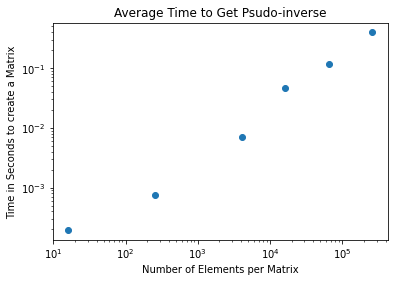

In [90]:
x = np.array([4,16,64,128,256,512])**2
invSVD_avg_nxn, invSVD_data_nxn = get_psudeoInv_avg(x, nxn_size, nxn_data, getInvSVD)

avg of 0th set: 0.00010850731900000001 s
avg of 1th set: 0.0016295686610000003 s
avg of 2th set: 0.065286132657 s
avg of 3th set: 0.2969323868 s
avg of 4th set: 1.8790944 s
avg of 5th set: 14.6777654264 s


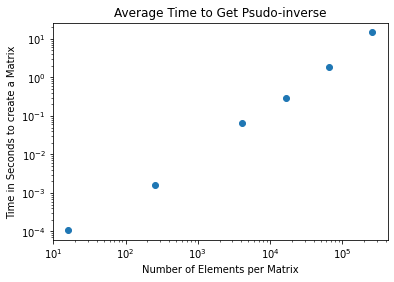

In [91]:
x = np.array([4,16,64,128,256,512])**2
invcholesky_avg_nxn, invcholesky_data_nxn = get_psudeoInv_avg(x, nxn_size, nxn_data, cholesky)

avg of 0th set: 0.000156595677 s
avg of 1th set: 0.001520552828 s
avg of 2th set: 0.022008734022 s
avg of 3th set: 0.09629523586000001 s
avg of 4th set: 0.32088891739000003 s
avg of 5th set: 1.75774686467 s


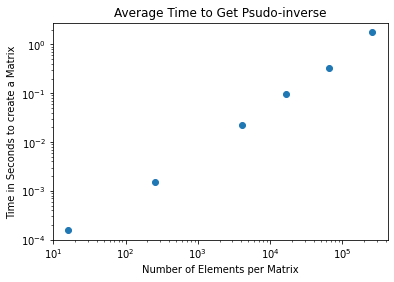

In [92]:
x = np.array([4,16,64,128,256,512])**2
invqr_avg_nxn, invqr_data_nxn = get_psudeoInv_avg(x, nxn_size, nxn_data, getQRinv)

avg of 0th set: 0.000260598677 s
avg of 1th set: 0.0015406672690000001 s
avg of 2th set: 0.017310846939 s
avg of 3th set: 0.06749701156 s
avg of 4th set: 0.22350045453 s
avg of 5th set: 0.7614337653700001 s


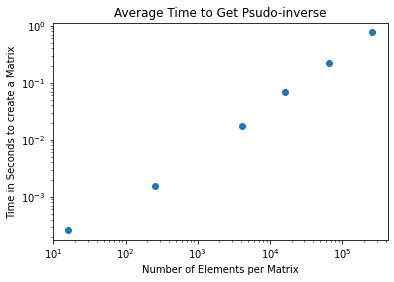

In [93]:
x = np.array([4,16,64,128,256,512])**2
invLUP_avg_nxn, invLUP_data_nxn = get_psudeoInv_avg(x, nxn_size, nxn_data, getLUPinv)

avg of 0th set: 1.9394597000000004e-05 s
avg of 1th set: 2.4963306000000002e-05 s
avg of 2th set: 0.00019157543800000002 s
avg of 3th set: 0.0010799431200000003 s
avg of 4th set: 0.00489216678 s
avg of 5th set: 0.025255521670000003 s


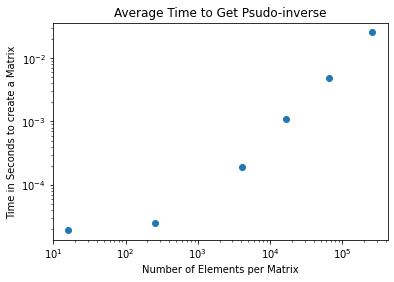

In [94]:
x = np.array([4,16,64,128,256,512])**2
inv_avg_nxn, inv_data_nxn = get_psudeoInv_avg(x, nxn_size, nxn_data, LA.inv)

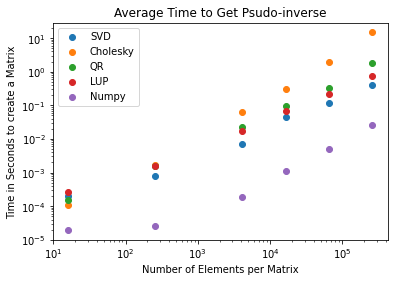

In [95]:
plt.scatter(x, invSVD_avg_nxn, label = 'SVD')
plt.scatter(x, invcholesky_avg_nxn, label = 'Cholesky')
plt.scatter(x, invqr_avg_nxn, label = 'QR')
plt.scatter(x, invLUP_avg_nxn, label = 'LUP')
plt.scatter(x, inv_avg_nxn, label = 'Numpy')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Elements per Matrix')
plt.ylabel('Time in Seconds to create a Matrix')
plt.title("Average Time to Get Psudo-inverse")
plt.legend()

###mxn

avg of 0th set: 0.000131200409 s
avg of 1th set: 0.000110449688 s
avg of 2th set: 0.000215956664 s
avg of 3th set: 0.0005748124200000001 s
avg of 4th set: 0.004246987410000001 s
avg of 5th set: 0.022273435190000003 s
avg of 6th set: 0.08581477384000001 s


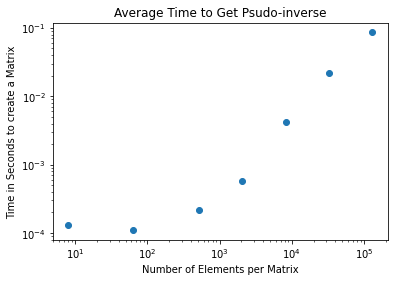

In [96]:
x = np.array([4,16,32,64,128,256,512]*np.array([2,4,16,32,64,128,256]))
mxn_data = [set4x2, set16x4, set32x16, set64x32, set128x64, set256x128, set512x256]
invSVD_avg_mxn, invSVD_data_mxn = get_psudeoInv_avg(x, mxn_size, mxn_data, getInvSVD)

avg of 0th set: 6.9804477e-05 s
avg of 1th set: 0.00010804466800000001 s
avg of 2th set: 0.001634872653 s
avg of 3th set: 0.008967469022000001 s
avg of 4th set: 0.06157835921 s
avg of 5th set: 0.297761675 s
avg of 6th set: 1.8642868922200002 s


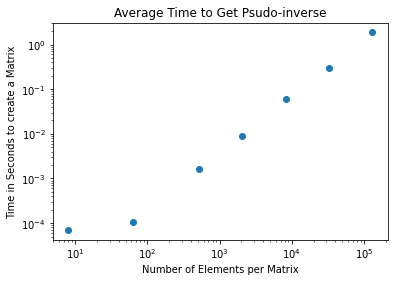

In [97]:
x = np.array([2,4,16,32,64,128,256])*np.array([4,16,32,64,128,256,512])
mxn_data = [set4x2, set16x4, set32x16, set64x32, set128x64, set256x128, set512x256]
invcholesky_avg_mxn, invcholesky_data_mxn = get_psudeoInv_avg(x, mxn_size, mxn_data, cholesky)

avg of 0th set: 9.9535915e-05 s
avg of 1th set: 0.00016584724700000002 s
avg of 2th set: 0.0015104218880000002 s
avg of 3th set: 0.005409463329000001 s
avg of 4th set: 0.02143341083 s
avg of 5th set: 0.09750240659000001 s
avg of 6th set: 0.30047606669000004 s


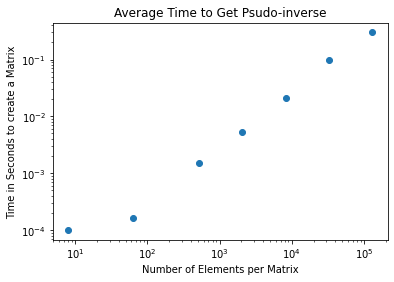

In [98]:
x = np.array([2,4,16,32,64,128,256])*np.array([4,16,32,64,128,256,512])
mxn_data = [set4x2, set16x4, set32x16, set64x32, set128x64, set256x128, set512x256]
invqr_avg_mxn, invqr_data_mxn = get_psudeoInv_avg(x, mxn_size, mxn_data, getQRpinv)

avg of 0th set: 0.000112730196 s
avg of 1th set: 0.00023934489600000003 s
avg of 2th set: 0.0016019507130000002 s
avg of 3th set: 0.005172247124 s
avg of 4th set: 0.018453749100000003 s
avg of 5th set: 0.06807976937000002 s
avg of 6th set: 0.22111648288000002 s


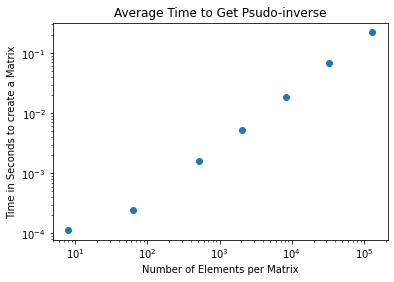

In [99]:
x = np.array([2,4,16,32,64,128,256])*np.array([4,16,32,64,128,256,512])
mxn_data = [set4x2, set16x4, set32x16, set64x32, set128x64, set256x128, set512x256]
invLUP_avg_mxn, invLUP_data_mxn = get_psudeoInv_avg(x, mxn_size, mxn_data, getLUPpinv)

avg of 0th set: 4.946084e-05 s
avg of 1th set: 5.4923767e-05 s
avg of 2th set: 0.000237894628 s
avg of 3th set: 0.000530695865 s
avg of 4th set: 0.0027025919900000002 s
avg of 5th set: 0.01051150674 s
avg of 6th set: 0.04409151622 s


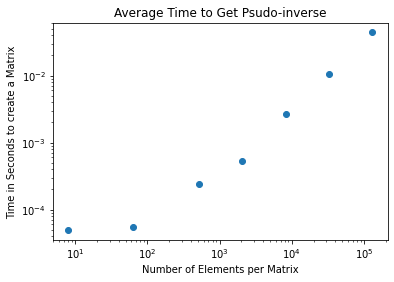

In [100]:
x = np.array([2,4,16,32,64,128,256])*np.array([4,16,32,64,128,256,512])
mxn_data = [set4x2, set16x4, set32x16, set64x32, set128x64, set256x128, set512x256]
inv_avg_mxn, inv_data_mxn = get_psudeoInv_avg(x, mxn_size, mxn_data, LA.pinv)

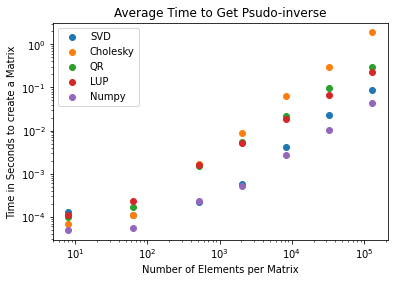

In [101]:
x = np.array([2,4,16,32,64,128,256])*np.array([4,16,32,64,128,256,512])
plt.scatter(x, invSVD_avg_mxn, label = 'SVD')
plt.scatter(x, invcholesky_avg_mxn, label = 'Cholesky')
plt.scatter(x, invqr_avg_mxn, label = 'QR')
plt.scatter(x, invLUP_avg_mxn, label = 'LUP')
plt.scatter(x, inv_avg_mxn, label = 'Numpy')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Elements per Matrix')
plt.ylabel('Time in Seconds to create a Matrix')
plt.title("Average Time to Get Psudo-inverse")
plt.legend()

##Irative Method

###Gradient-based algorithm
A gradient based algorithm for solving the unique minimum Forbenius norm solution of AXA = A

$f(X) = \frac{1}{2}||A-AXA||^2_F$

$\frac{\partial f(X)}{\partial X} = -A^*(A-AXA)A^*$

$X_k=X_{k-1}-\mu\frac{\partial}{\partial X} = X_{k-1}+A^*(A-AX_{k-1}A)A^*$

Where $X_i=A^*$ and $A^\dagger = X_f$

###Ben-Izrael

An iterative algorithm for obtaining the generalized inverse $A^+$ whenever $X_0$ approximates $A^{-1}$.

$X_{n+1}=X_n(2I-AX_n)$

In [102]:
def iterStep(A,X):
  return X@(2*np.eye(A.shape[0])-A@X)

def BIinv(A, n, error = 1e-10):
  X = 1/2000*A.T
  for _ in range(n):
    if (np.abs((X@A) - np.eye(np.min(A.shape)))).sum() < error:
      return X
    X = iterStep(A,X)
  return X

iter = 100

In [103]:
def get_psudeoInv_avg_iter(x, mxn_size, mxn_data, f, iter):
  """
  function to calculate psudo-inverse and collact data on its average
  x : x axis which tells the total number of elements for each dataset
  mxnsize : array which contains the total number of matrices for each dataset
  mxn_data : array which contains the dataset
  f : function f(A)=A^-1, which calculates the psudeo-inverse a matrix at a time

  Return:
  inv_avg : avg time of each set
  inv_data : the psudo-invereted matrices
  """
  if len(x) != len(mxn_size):
    print("x doesn't match mxn_size array")
    return 
  if len(mxn_data) != len(mxn_data):
    print("dataset size doesn't match nsize")
    return 
  size = len(x)
  inv_avg = [None]*size
  inv_data = [None]*size
  for i in range(size):
    t0 = time.time_ns()
    inv_data[i] = [f(i, iter) for i in mxn_data[i]]
    t1 = time.time_ns()
    avg = (t1-t0)/(mxn_size[i])*1e-9
    inv_avg[i] = avg
    print(f"avg of {i}th set: {avg} s")
  plt.scatter(x, inv_avg)  # Plot of average time to invert matrix
  plt.xscale('log')
  plt.yscale('log')
  plt.xlabel('Number of Elements per Matrix')
  plt.ylabel('Time in Seconds to create a Matrix')
  plt.title("Average Time to Get Psudo-inverse")
  return inv_avg, inv_data

###nxn

avg of 0th set: 0.0007818870900000001 s
avg of 1th set: 0.001114933415 s
avg of 2th set: 0.0050937125 s
avg of 3th set: 0.07894079997 s


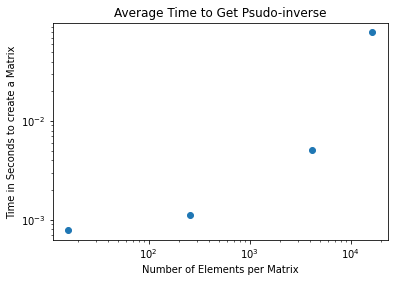

In [104]:
x = np.array([4,16,64,128])**2
invbi_avg_nxn, invbi_data_nxn = get_psudeoInv_avg_iter(x, nxn_size[:4], nxn_data[:4], BIinv, iter)

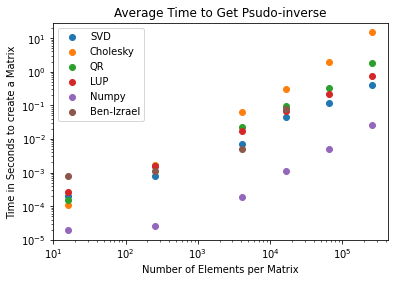

In [105]:
x = np.array([4,16,64,128,256,512])**2
plt.scatter(x, invSVD_avg_nxn, label = 'SVD')
plt.scatter(x, invcholesky_avg_nxn, label = 'Cholesky')
plt.scatter(x, invqr_avg_nxn, label = 'QR')
plt.scatter(x, invLUP_avg_nxn, label = 'LUP')
plt.scatter(x, inv_avg_nxn, label = 'Numpy')
x = np.array([4,16,64,128])**2
x = np.array([4,16,64,128])**2
plt.scatter(x, invbi_avg_nxn, label = 'Ben-Izrael')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Elements per Matrix')
plt.ylabel('Time in Seconds to create a Matrix')
plt.title("Average Time to Get Psudo-inverse")
plt.legend()
plt.savefig("nxn_average_time.png", dpi=300)

###mxn

avg of 0th set: 0.0005271534000000001 s
avg of 1th set: 0.000602635879 s
avg of 2th set: 0.000705965508 s
avg of 3th set: 0.001245045353 s
avg of 4th set: 0.00894897889 s


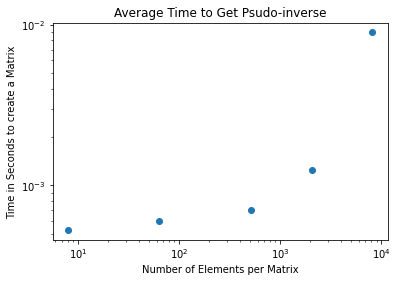

In [106]:
x = np.array([2,4,16,32,64])*np.array([4,16,32,64,128])
invbi_avg_mxn, invbi_data_mxn = get_psudeoInv_avg_iter(x, mxn_size[0:5], mxn_data[0:5], BIinv, iter)

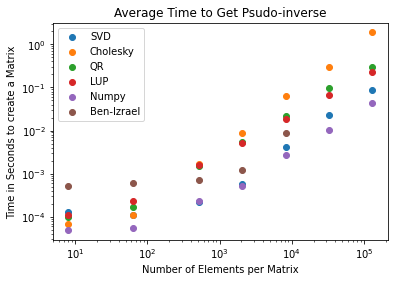

In [107]:
x = np.array([2,4,16,32,64,128,256])*np.array([4,16,32,64,128,256,512])
plt.scatter(x, invSVD_avg_mxn, label = 'SVD')
plt.scatter(x, invcholesky_avg_mxn, label = 'Cholesky')
plt.scatter(x, invqr_avg_mxn, label = 'QR')
plt.scatter(x, invLUP_avg_mxn, label = 'LUP')
plt.scatter(x, inv_avg_mxn, label = 'Numpy')
x = np.array([2,4,16,32,64])*np.array([4,16,32,64,128])
plt.scatter(x, invbi_avg_mxn, label = 'Ben-Izrael')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Elements per Matrix')
plt.ylabel('Time in Seconds to create a Matrix')
plt.title("Average Time to Get Psudo-inverse")
plt.legend()
plt.savefig("mxn_average_time.png", dpi=300)

#Accuracy of Inverses

In [108]:
def InvError(A,B):
  """
  A : Left matrix
  B : Right matrix
  """
  return np.abs(np.eye(np.min(A.shape[0:2])) - A@B).sum()

def getInvError(setA, setB):
  """
  setA : left matrix dataset
  setB : right matrix dataset

  Return:
  inverse error
  """
  inv_error = [None]*len(setB)
  inv_sd = [None]*len(setB)

  for i in range(len(setB)):  # loop over different datasets and inverse datasets
    B = setB[i]
    A = setA[i]
    C = np.zeros(len(B))
    for j in range(len(B)):  # loop over each item
      C[j] = InvError(A[j],B[j])  # add up error of each matrix
    inv_error[i] = C.mean()  # mean error of dataset
    inv_sd[i] = C.std()  # mean error of dataset
  return inv_error, inv_sd

Check that inverses work

9.445429773077044e-12


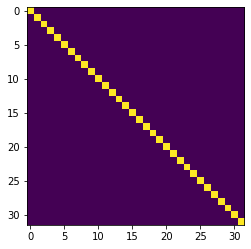

In [109]:
print(InvError(invSVD_data_mxn[3][0],mxn_data[3][0]))
plt.imshow(invSVD_data_mxn[3][0]@mxn_data[3][0])

2.4170121066589934e-12


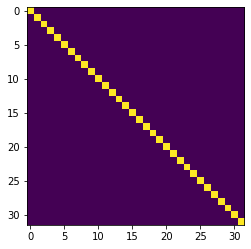

In [110]:
print(InvError(invcholesky_data_mxn[3][0],mxn_data[3][0]))
plt.imshow(invcholesky_data_mxn[3][0]@mxn_data[3][0])

1.9033684126195713e-12


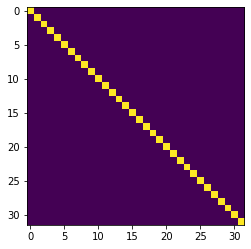

In [111]:
print(InvError(invLUP_data_mxn[3][0],mxn_data[3][0]))
plt.imshow(invLUP_data_mxn[3][0]@mxn_data[3][0])

4.546410257330147e-10


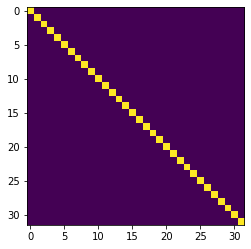

In [112]:
print(InvError(invqr_data_mxn[3][0],mxn_data[3][0]))
plt.imshow(invqr_data_mxn[3][0]@mxn_data[3][0])

586675.2450519048


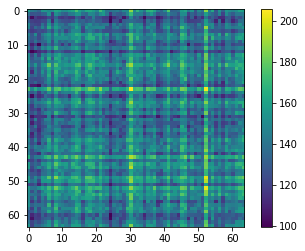

In [113]:
print(InvError(invgd_data_nxn[2][0],nxn_data[2][0]))
plt.imshow(invgd_data_nxn[2][0]@nxn_data[2][0])
plt.colorbar()

17584.108436189337


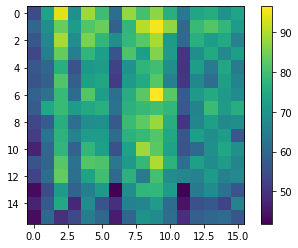

In [114]:
print(InvError(invgd_data_mxn[2][0],mxn_data[2][0]))
plt.imshow(invgd_data_mxn[2][0]@mxn_data[2][0])
plt.colorbar()

1.146833360592193e-12


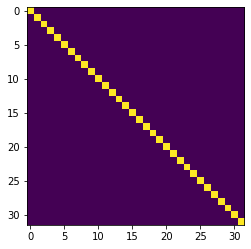

In [115]:
print(InvError(invbi_data_mxn[3][0],mxn_data[3][0]))
plt.imshow(invbi_data_mxn[3][0]@mxn_data[3][0])

##nxn

In [116]:
invSVD_data_nxn  # inverses of SVD
nxn_data  # dataset

invSVD_error = [None]*len(invSVD_data_nxn)

for i in range(len(invSVD_data_nxn)):  # loop over different datasets and inverse datasets
  B = invSVD_data_nxn[i]
  A = nxn_data[i]
  C = np.zeros(len(B))
  for j in range(len(B)):  # loop over each item
    C[j] = InvError(A[j],B[j])  # add up error of each matrix
  invSVD_error[i] = (C.sum())/(len(B)*A[0].shape[0]*A[0].shape[1])  # sum up error of dataset. Divide by total length to get average. Also divide by total number of elements

In [117]:
inverror_svd, inv_sd_svd = getInvError(invSVD_data_nxn, nxn_data)
inverror_cholesky, inv_sd_cholsky = getInvError(invcholesky_data_nxn, nxn_data)
inverror_qr, inv_sd_qr = getInvError(invqr_data_nxn, nxn_data)
inverror_LUP, inv_sd_LUP = getInvError(invLUP_data_nxn, nxn_data)
inverror, inv_sd = getInvError(inv_data_nxn, nxn_data)
inverror_bi, inv_sd_bi = getInvError(invbi_data_nxn, nxn_data[0:4])

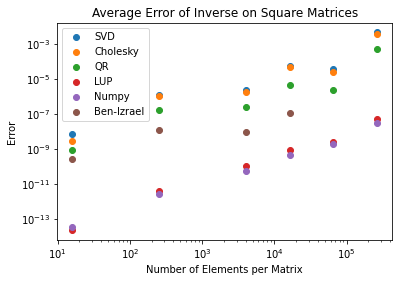

In [118]:
x = np.array([4,16,64,128,256,512])**2
plt.scatter(x, inverror_svd, label = 'SVD')
plt.scatter(x, inverror_cholesky, label = 'Cholesky')
plt.scatter(x, inverror_qr, label = 'QR')
plt.scatter(x, inverror_LUP, label = 'LUP')
plt.scatter(x, inverror, label = 'Numpy')
x = np.array([4,16,64,128])**2
x = np.array([4,16,64,128])**2
plt.scatter(x, inverror_bi, label = 'Ben-Izrael')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Elements per Matrix')
plt.ylabel('Error')
plt.title("Average Error of Inverse on Square Matrices")
plt.legend()
plt.savefig("nxn_average_error.png", dpi=300)

##mxn

In [119]:
mxn_data = [set4x2, set16x4, set32x16, set64x32, set128x64, set256x128, set512x256]
inverror_svd_, inv_sd_svd_ = getInvError(invSVD_data_mxn, mxn_data)
inverror_cholesky_, inv_sd_cholsky_ = getInvError(invcholesky_data_mxn, mxn_data)
inverror_qr_, inv_sd_qr_ = getInvError(invqr_data_mxn, mxn_data)
inverror_LUP_, inv_sd_LUP_ = getInvError(invLUP_data_mxn, mxn_data)
inverror_, inv_sd_ = getInvError(inv_data_mxn, mxn_data)
inverror_bi_, inv_sd_bi_ = getInvError(invbi_data_mxn, mxn_data[0:5])

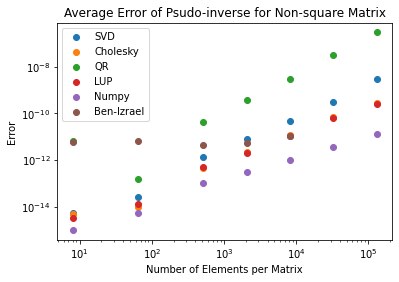

In [120]:
x = np.array([2,4,16,32,64,128,256])*np.array([4,16,32,64,128,256,512])
plt.scatter(x, inverror_svd_, label = 'SVD')
plt.scatter(x, inverror_cholesky_, label = 'Cholesky')
plt.scatter(x, inverror_qr_, label = 'QR')
plt.scatter(x, inverror_LUP_, label = 'LUP')
plt.scatter(x, inverror_, label = 'Numpy')
x = np.array([2,4,16,32,64])*np.array([4,16,32,64,128])
plt.scatter(x, inverror_bi_, label = 'Ben-Izrael')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Elements per Matrix')
plt.ylabel('Error')
plt.title("Average Error of Psudo-inverse for Non-square Matrix")
plt.legend()
plt.savefig("mxn_average_error.png", dpi=300)

#Danny's Problem

In [121]:
IBMQ.save_account('4155b71f22eb3c7c385dcceb3b445f95a6f7b517d67336eac6b6bdce842c869e3fca7a5bca1d97a2331e689d3af55083ebc25b8451a028e28901936b3c5ea527',overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider()
backend=provider.get_backend('ibmq_bogota')
noise_model = NoiseModel.from_backend(backend)
sim = Aer.get_backend('qasm_simulator')

ibmqfactory.load_account:WARNING:2022-05-04 18:24:18,487: Credentials are already in use. The existing account in the session will be replaced.
/usr/local/lib/python3.7/dist-packages/qiskit/providers/aer/noise/device/models.py:266: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (258730.94416223024 > 2 * 115148.38353876387). Truncating to maximum value.
  " Truncating to maximum value.", UserWarning)
/usr/local/lib/python3.7/dist-packages/qiskit/providers/aer/noise/device/models.py:266: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (258730.94416223024 > 2 * 115148.38353876387). Truncating to maximum value.
  " Truncating to maximum value.", UserWarning)
/usr/local/lib/python3.7/dist-packages/qiskit/providers/aer/noise/device/models.py:266: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2

In [122]:
def calmatrix(n):
  calM = []
  for i in range(n):
    qr = qiskit.QuantumRegister(5)
    qubit_list = [2,3,4]
    meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')

    job = qiskit.execute(meas_calibs, backend=sim, shots=10000, noise_model=noise_model)
    cal_results = job.result()

    meas_fitter = CompleteMeasFitter(cal_results, state_labels, qubit_list=qubit_list, circlabel='mcal')
    calM.append(meas_fitter.cal_matrix)
  return calM

$|GHZ\rangle = \frac{|000\rangle+|111\rangle}{\sqrt{2}}$

In [123]:
# Make a 3Q GHZ state
qr = qiskit.QuantumRegister(5,'q')
cr = ClassicalRegister(3)
ghz = QuantumCircuit(qr, cr)
ghz.h(qr[2])
ghz.cx(qr[2], qr[3])
ghz.cx(qr[3], qr[4])
ghz.measure(qr[2],cr[0])
ghz.measure(qr[3],cr[1])
ghz.measure(qr[4],cr[2])
circuit_drawer(ghz)

q_0: ────────────────────────
                                
   q_1: ────────────────────────
        ┌───┐          ┌─┐      
   q_2: ┤ H ├──■───────┤M├──────
        └───┘┌─┴─┐     └╥┘┌─┐   
   q_3: ─────┤ X ├──■───╫─┤M├───
             └───┘┌─┴─┐ ║ └╥┘┌─┐
   q_4: ──────────┤ X ├─╫──╫─┤M├
                  └───┘ ║  ║ └╥┘
c201: 3/════════════════╩══╩══╩═
                        0  1  2

In [124]:
job_noise = qiskit.execute([ghz], backend=sim, shots=10000, noise_model=noise_model)
job_sim = qiskit.execute([ghz], backend=sim, shots=10000)
results_n = job_noise.result()
results_s = job_sim.result()
# Results without mitigation
raw_counts_n = results_n.get_counts()
raw_counts_s = results_s.get_counts()

count_noise = (1/10000)*np.array([raw_counts_n['000'],
                   raw_counts_n['001'],
                   raw_counts_n['010'],
                   raw_counts_n['011'],
                   raw_counts_n['100'],
                   raw_counts_n['101'],
                   raw_counts_n['110'],
                   raw_counts_n['111']])

count_s = (1/10000)*np.array([[raw_counts_s['000'],
                     0,
                     0,
                     0,
                     0,
                     0,
                     0,
                     raw_counts_s['111']]])

In [125]:
CALM = calmatrix(100)

In [126]:
CALM =np.array(CALM).reshape(-1,8,8)

In [127]:
CALM2 = [CALM,CALM]

SVD
avg of 0th set: 0.00024810585 s
avg of 1th set: 0.00011877671000000001 s
chol
avg of 0th set: 0.00032627167 s
avg of 1th set: 0.0005293821700000001 s
qr
avg of 0th set: 0.00043820235 s
avg of 1th set: 0.00049163432 s
lup
avg of 0th set: 0.0006955216200000001 s
avg of 1th set: 0.00054942713 s
bi
avg of 0th set: 0.0008755100400000001 s
avg of 1th set: 0.0006423517700000001 s


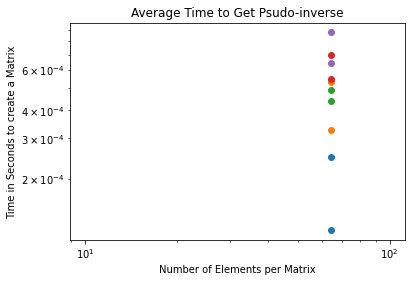

In [128]:
x = np.array([8,8])**2
number = [100,100]
iter =100
print('SVD')
invSVD_avg, svdinv = get_psudeoInv_avg(x, number, CALM2, getInvSVD)
print('chol')
invChol_avg, cholinv = get_psudeoInv_avg(x, number, CALM2, cholesky)
print('qr')
invqr_avg, qrinv = get_psudeoInv_avg(x, number, CALM2, getQRinv)
print('lup')
invlup_avg, lupinv = get_psudeoInv_avg(x, number, CALM2, getLUPinv)
print('bi')
invbi_avg_nxn, biinv = get_psudeoInv_avg_iter(x, number, CALM2, BIinv, iter)

In [129]:
svdinv1 = svdinv[0]@count_noise.T
cholinv1 = cholinv[0]@count_noise.T
qrinv1 = qrinv[0]@count_noise.T
lupinv1 = lupinv[0]@count_noise.T
biinv1 = biinv[0]@count_noise.T

In [130]:

svdinv = [getInvSVD(i)@count_noise.T for i in CALM]
cholinv = [cholesky(i)@count_noise.T for i in CALM]
qrinv = [getQRinv(i)@count_noise.T for i in CALM]
lupinv = [getLUPinv(i)@count_noise.T for i in CALM]
gdinv = [Piter(i,100)@count_noise.T for i in CALM]
biinv = [BIinv(i,100)@count_noise.T for i in CALM]

In [131]:
CALM = calmatrix(100)
Truinv = [LA.inv(i)@count_noise.T for i in CALM]
svdinv = [getInvSVD(i)@count_noise.T for i in CALM]
cholinv = [cholesky(i)@count_noise.T for i in CALM]
qrinv = [getQRinv(i)@count_noise.T for i in CALM]
lupinv = [getLUPinv(i)@count_noise.T for i in CALM]
gdinv = [Piter(i,100)@count_noise.T for i in CALM]
biinv = [BIinv(i,100)@count_noise.T for i in CALM]

In [132]:
Truinv = [LA.inv(i)@count_noise.T for i in CALM]

In [133]:
Tru_mean = np.mean(Truinv,axis=0)
Tru_std = np.std(Truinv,axis=0)
svd_mean = np.mean(svdinv1,axis=0)
svd_std = np.std(svdinv1,axis=0)
chol_mean = np.mean(cholinv1,axis=0)
chol_std = np.std(cholinv1,axis=0)
qr_mean = np.mean(qrinv1,axis=0)
qr_std = np.std(qrinv1,axis=0)
lup_mean = np.mean(lupinv1,axis=0)
lup_std = np.std(lupinv1,axis=0)
bi_mean = np.mean(biinv1,axis=0)
bi_std = np.std(biinv1,axis=0)

In [134]:
print(np.shape(svdinv1))

(100, 8)


In [135]:
svd_mean

array([ 4.93681488e-01,  2.38122137e-04,  1.89680443e-03,  4.58894968e-03,
       -4.30658141e-04,  1.55446046e-03,  8.49497183e-03,  4.89975862e-01])

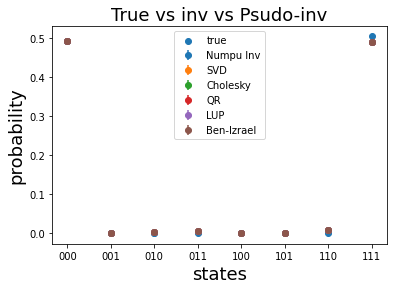

In [136]:
x = ['000','001','010','011','100','101','110','111']
plt.scatter(x,count_s.T,label='true')
plt.errorbar(x,Tru_mean,yerr=Tru_std,fmt="o",label='Numpu Inv')
plt.errorbar(x,svd_mean,yerr=svd_std,fmt="o",label='SVD')
plt.errorbar(x,chol_mean,yerr=chol_std,fmt="o",label='Cholesky')
plt.errorbar(x,qr_mean,yerr=qr_std,fmt="o",label='QR')
plt.errorbar(x,lup_mean,yerr=lup_std,fmt="o",label='LUP')
plt.errorbar(x,bi_mean,yerr=bi_std,fmt="o",label='Ben-Izrael')
plt.ylabel('probability',fontsize=18)
plt.xlabel('states',fontsize=18)
plt.title('True vs inv vs Psudo-inv',fontsize=18)
plt.legend()
plt.savefig("Danny_truevspsudo.png", dpi=300)

In [137]:
print('Error svd',abs(svd_mean-count_s))
print('Error chol',abs(chol_mean-count_s))
print('Error qr',abs(qr_mean-count_s))
print('Error lup',abs(lup_mean-count_s))
print('Error Ben-Izrael',abs(bi_mean-count_s))

Error svd [[0.00061851 0.00023812 0.0018968  0.00458895 0.00043066 0.00155446
  0.00849497 0.01572414]]
Error chol [[0.00061851 0.00023812 0.0018968  0.00458895 0.00043066 0.00155446
  0.00849497 0.01572414]]
Error qr [[0.00061851 0.00023812 0.0018968  0.00458895 0.00043066 0.00155446
  0.00849497 0.01572414]]
Error lup [[0.00061851 0.00023812 0.0018968  0.00458895 0.00043066 0.00155446
  0.00849497 0.01572414]]
Error Ben-Izrael [[0.00061851 0.00023812 0.0018968  0.00458895 0.00043066 0.00155446
  0.00849497 0.01572414]]


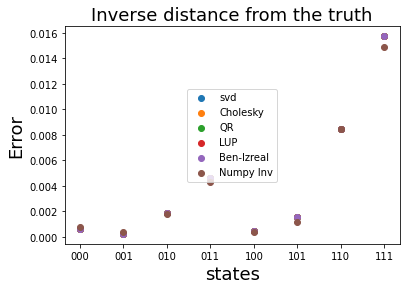

In [138]:
plt.scatter(x,abs(svd_mean-count_s),label='svd')
plt.scatter(x,abs(chol_mean-count_s),label='Cholesky')
plt.scatter(x,abs(qr_mean-count_s),label='QR')
plt.scatter(x,abs(lup_mean-count_s),label='LUP')
plt.scatter(x,abs(bi_mean-count_s),label='Ben-Izreal')
plt.scatter(x,abs(Tru_mean-count_s),label='Numpy Inv')
plt.title('Inverse distance from the truth',fontsize=18)
plt.ylabel('Error',fontsize=18)
plt.xlabel('states',fontsize=18)
plt.legend(loc='center')
plt.savefig("Danny_inversedistfromtruth.png", dpi=300)

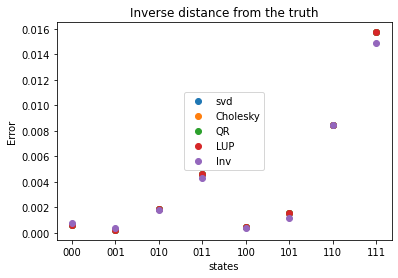

In [139]:
plt.scatter(x,abs(svd_mean-count_s),label='svd')
plt.scatter(x,abs(chol_mean-count_s),label='Cholesky')
plt.scatter(x,abs(qr_mean-count_s),label='QR')
plt.scatter(x,abs(lup_mean-count_s),label='LUP')
plt.scatter(x,abs(Tru_mean-count_s),label='Inv')
plt.title('Inverse distance from the truth')
plt.ylabel('Error')
plt.xlabel('states')
plt.legend(loc='center')
plt.savefig("Danny_inversedistfromtruth.png", dpi=300)

# Anthony's Problem